In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 5)

def load_spectrum(file_df, file_db):
    """Laad Doppler free (DF) en Doppler broadened (DB) uit twee CSV bestanden."""
    df_df = pd.read_csv(file_df, skiprows=20, header=None)
    df_db = pd.read_csv(file_db, skiprows=20, header=None)

    # Doppler free
    x1 = pd.to_numeric(df_df[3], errors="coerce")
    y1 = pd.to_numeric(df_df[4], errors="coerce")
    mask1 = (~x1.isna()) & (~y1.isna())
    x1 = x1[mask1].reset_index(drop=True)
    y1 = y1[mask1].reset_index(drop=True)

    # Doppler broadened
    x2 = pd.to_numeric(df_db[3], errors="coerce")
    y2 = pd.to_numeric(df_db[4], errors="coerce")
    mask2 = (~x2.isna()) & (~y2.isna())
    x2 = x2[mask2].reset_index(drop=True)
    y2 = y2[mask2].reset_index(drop=True)

    return x1, y1, x2, y2

def align_spectra_on_minimum(x_df, y_df, x_db, y_db):
    """
    Maak x-grid gelijk door DF op DB te interpoleren.
    Eerst schuif DF zodat de minima samenvallen, daarna interpolate.
    Retourneert x_common, y_df_aligned, y_db_common.
    """
    x_df = np.asarray(x_df)
    y_df = np.asarray(y_df)
    x_db = np.asarray(x_db)
    y_db = np.asarray(y_db)

    # index van minima
    idx_df = np.argmin(y_df)
    idx_db = np.argmin(y_db)

    # hoeveel tijd moeten we DF verschuiven zodat minima gelijk liggen
    shift = x_db[idx_db] - x_df[idx_df]
    x_df_shifted = x_df + shift

    # gemeenschappelijk bereik
    xmin = max(x_df_shifted.min(), x_db.min())
    xmax = min(x_df_shifted.max(), x_db.max())
    mask = (x_db >= xmin) & (x_db <= xmax)

    x_common = x_db[mask]
    y_db_common = y_db[mask]

    # interpolate DF naar x_common
    y_df_interp = np.interp(x_common, x_df_shifted, y_df)

    return x_common, y_df_interp, y_db_common

def gaussian(f, A, f0, sigma, offset):
    return offset + A * np.exp(-(f - f0)**2 / (2*sigma**2))

def lorentzian(f, A, f0, gamma, offset):
    return offset + A * gamma**2 / ((f - f0)**2 + gamma**2)






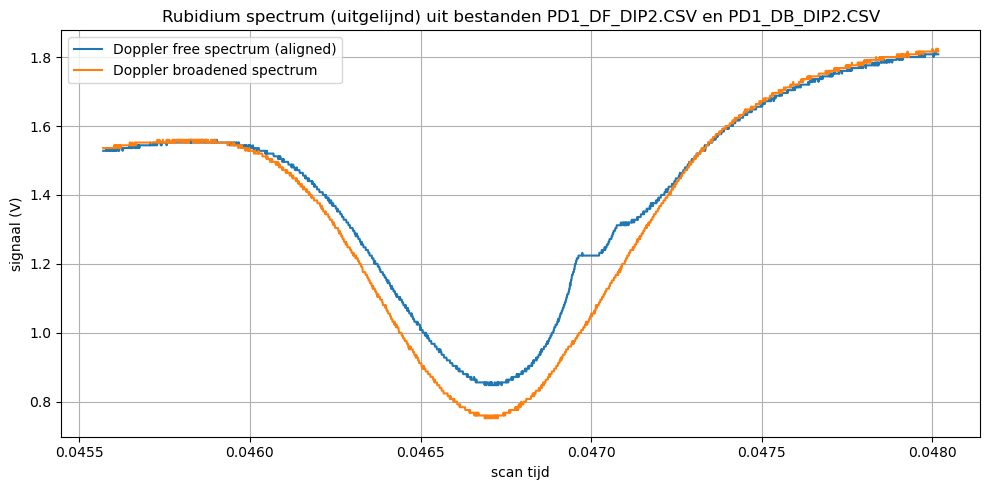

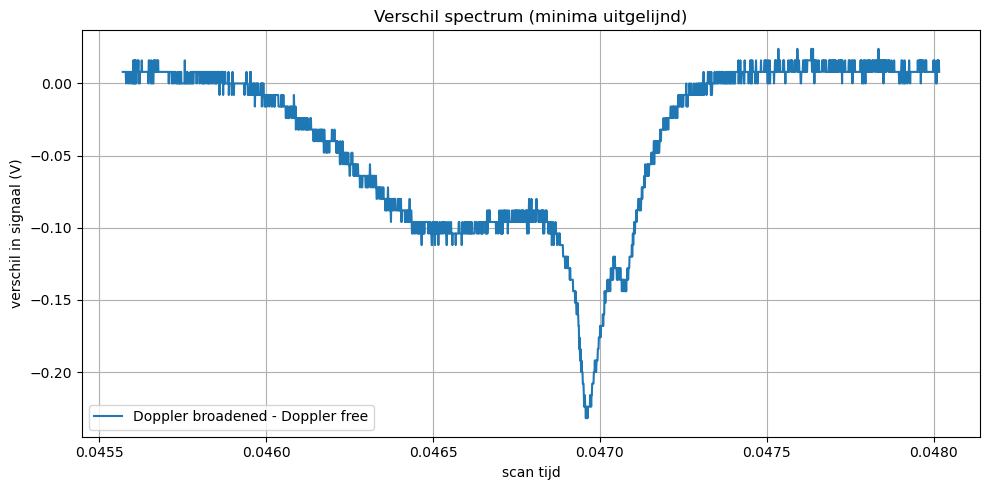

In [22]:
# KIES HIER WELKE CSV bestanden je wilt gebruiken

# PD1 DIP1
file_df = "PD1_DF_DIP2.CSV"   # Doppler free
file_db = "PD1_DB_DIP2.CSV"   # Doppler broadened

# andere opties:
# PD1 DIP2
# file_df = "PD1_DF_DIP2.CSV"
# file_db = "PD1_DB_DIP2.CSV"

# PD2 DIP1
# file_df = "PD2_DF_DIP1.CSV"
# file_db = "PD2_DB_DIP1.CSV"

# PD2 DIP2
# file_df = "PD2_DF_DIP2.CSV"
# file_db = "PD2_DB_DIP2.CSV"

# 1) laad ruwe data
x1_raw, y1_raw, x2_raw, y2_raw = load_spectrum(file_df, file_db)

# 2) align + interpolate zodat minima samenvallen
x_common, y1_aligned, y2_common = align_spectra_on_minimum(x1_raw, y1_raw, x2_raw, y2_raw)

# zet terug in pandas Series (fijn voor later)
x1 = pd.Series(x_common)         # tijd-as (nu gelijk voor beide)
x2 = x1.copy()                   # zelfde as
y1 = pd.Series(y1_aligned)       # Doppler free, uitgelijnd
y2 = pd.Series(y2_common)        # Doppler broadened

# 3) verschil: BROADENED - FREE
y_diff = y2 - y1

# Plot beide spectra
plt.figure()
plt.plot(x1, y1, label="Doppler free spectrum (aligned)")
plt.plot(x2, y2, label="Doppler broadened spectrum")
plt.xlabel("scan tijd")
plt.ylabel("signaal (V)")
plt.title(f"Rubidium spectrum (uitgelijnd) uit bestanden {file_df} en {file_db}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot DB - DF
plt.figure()
plt.plot(x1, y_diff, label="Doppler broadened - Doppler free")
plt.xlabel("scan tijd")
plt.ylabel("verschil in signaal (V)")
plt.title("Verschil spectrum (minima uitgelijnd)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Totaal gevonden kandidaten: 15
Beschikbare properties: dict_keys(['prominences', 'left_bases', 'right_bases'])
Indices van de 2 diepste dips (in sub-array): [457 575]
Indices in volledige array: [1388 1506]


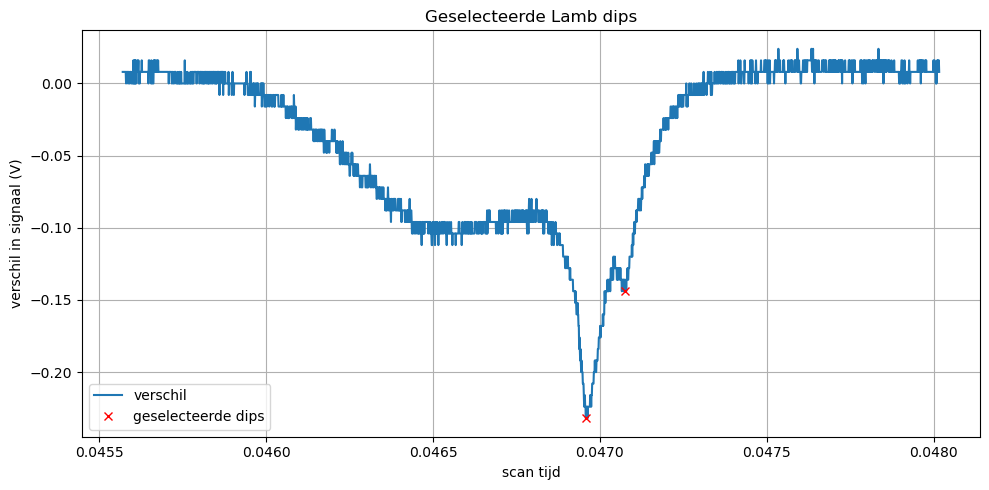

In [25]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# werk op het verschil-signaal y_diff en tijd-as x1

# venster kiezen rondom de interessante dips
mask = (x1 > 0.0465) & (x1 < 0.0475)   # pas grenzen aan als nodig
x_sub = x1[mask].to_numpy()
y_sub = y_diff[mask].to_numpy()

# zoek dips: pieken in -y_sub
peaks_all, props = find_peaks(
    -y_sub,
    distance=50,        # mag je aanpassen
    prominence=0.003    # onder deze diepte negeert hij ruis
)

print("Totaal gevonden kandidaten:", len(peaks_all))
print("Beschikbare properties:", props.keys())

# sorteer op prominence (diepte) en kies de 2 diepste dips
order = np.argsort(props["prominences"])[::-1]
main_peaks = peaks_all[order[:2]]

print("Indices van de 2 diepste dips (in sub-array):", main_peaks)

# zet ze terug naar indices in de originele arrays
global_peaks = np.where(mask)[0][main_peaks]
print("Indices in volledige array:", global_peaks)

# plot ter controle
plt.figure()
plt.plot(x1, y_diff, label="verschil")
plt.plot(x1.iloc[global_peaks], y_diff.iloc[global_peaks], "rx", label="geselecteerde dips")
plt.xlabel("scan tijd")
plt.ylabel("verschil in signaal (V)")
plt.title("Geselecteerde Lamb dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




alpha = 1975200000000.0552 Hz per tijdseenheid
beta  = -74052051800.00208 Hz bij tijd nul


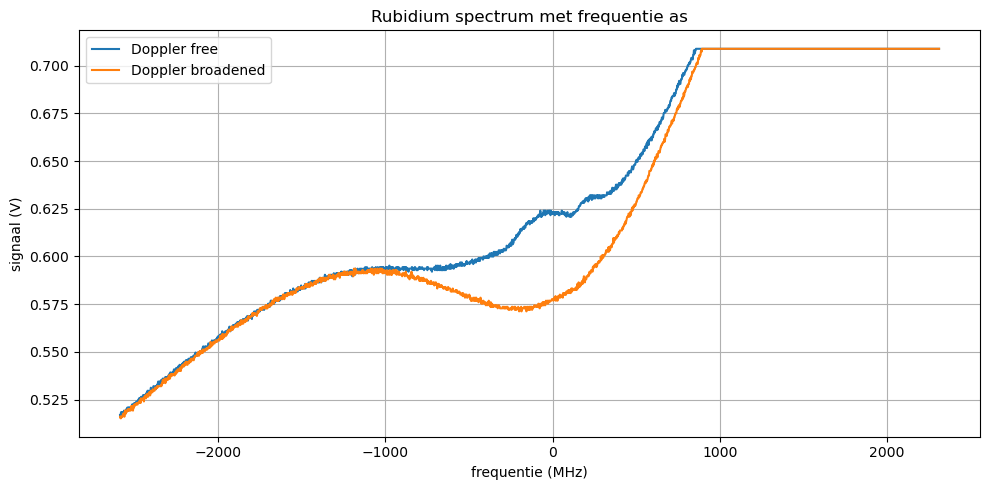

In [19]:
# KIES HIER TWEE REFERENTIE DIPS EN HUN BEKENDE FREQUENTIES

# voorbeeld: vervang deze vier regels door jouw keuze
i1 = 1272      # eerste dip
i2 = 1407      # tweede dip

nu1_MHz = -72.911    # overgang F=2 -> F'=2
nu2_MHz = 193.741    # overgang F=2 -> F'=3

# vanaf hier niets meer aanpassen

t1 = x1.iloc[i1]
t2 = x1.iloc[i2]

nu1 = nu1_MHz * 1e6
nu2 = nu2_MHz * 1e6

alpha = (nu2 - nu1) / (t2 - t1)
beta  = nu1 - alpha * t1

freq1 = alpha * x1 + beta
freq2 = alpha * x2 + beta

freq1_MHz = freq1 / 1e6
freq2_MHz = freq2 / 1e6

print("alpha =", alpha, "Hz per tijdseenheid")
print("beta  =", beta, "Hz bij tijd nul")

plt.figure()
plt.plot(freq1_MHz, y1, label="Doppler free")
plt.plot(freq2_MHz, y2, label="Doppler broadened")
plt.xlabel("frequentie (MHz)")
plt.ylabel("signaal (V)")
plt.title("Rubidium spectrum met frequentie as")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Gaussian fit Doppler verbrede lijn:
  centrum frequentie f0 = -2641.13 MHz
  sigma = 58.80 MHz
  FWHM (Doppler broadening) = 138.47 MHz


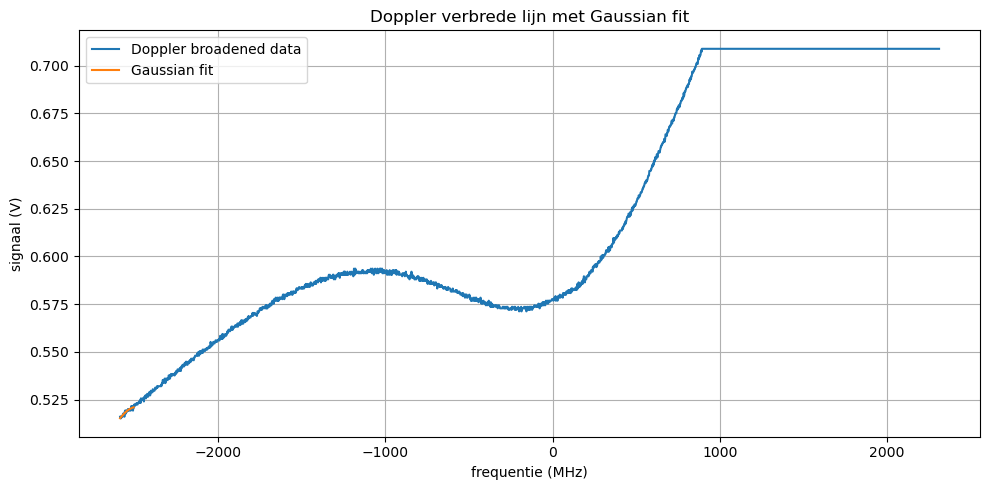

In [20]:
import numpy as np
from scipy.optimize import curve_fit

def gaussian_simple(f, A, f0, sigma):
    """Eenvoudige Gaussian zonder offset (voor positieve piek)."""
    return A * np.exp(-(f - f0)**2 / (2 * sigma**2))

# 1) zoek globale dip in Doppler broadened spectrum
idx_min_D = np.argmin(y2.values)         # index van minimum
f_center_D = freq2_MHz.iloc[idx_min_D]   # geschatte centrumfrequentie

# 2) kies venster rond deze dip
window_MHz = 80.0   # pas aan als nodig (groter/kleiner proberen)
mask_D = (freq2_MHz > f_center_D - window_MHz) & (freq2_MHz < f_center_D + window_MHz)

f_D = freq2_MHz[mask_D].to_numpy()
y_D = y2[mask_D].to_numpy()

# 3) maak van de dip een positieve piek en haal ongeveer de offset weg
y_peak = y_D.max() - y_D   # rond de dip wordt dit groot, verder ~0

# 4) startschatting voor parameters
A0 = y_peak.max()
f0_0 = f_center_D
sigma0 = window_MHz / 4.0

p0 = [A0, f0_0, sigma0]

# 5) fit Gaussian aan de positieve piek
pars_G, _ = curve_fit(gaussian_simple, f_D, y_peak, p0=p0, maxfev=10000)
A_G, f0_G, sigma_G = pars_G

# 6) FWHM uit sigma
FWHM_D = 2 * np.sqrt(2 * np.log(2)) * sigma_G

print("Gaussian fit Doppler verbrede lijn:")
print(f"  centrum frequentie f0 = {f0_G:.2f} MHz")
print(f"  sigma = {sigma_G:.2f} MHz")
print(f"  FWHM (Doppler broadening) = {FWHM_D:.2f} MHz")

# 7) plot: originele data + terug-gespiegelde fit
y_fit_D = y_D.max() - gaussian_simple(f_D, *pars_G)

plt.figure()
plt.plot(freq2_MHz, y2, label="Doppler broadened data")
plt.plot(f_D, y_fit_D, label="Gaussian fit")
plt.xlabel("frequentie (MHz)")
plt.ylabel("signaal (V)")
plt.title("Doppler verbrede lijn met Gaussian fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Lorentzian fit Lamb dip:
  centrum frequentie f0 = -73.43 MHz
  gamma = 1.06 MHz
  FWHM (linewidth overgang) = 2.12 MHz


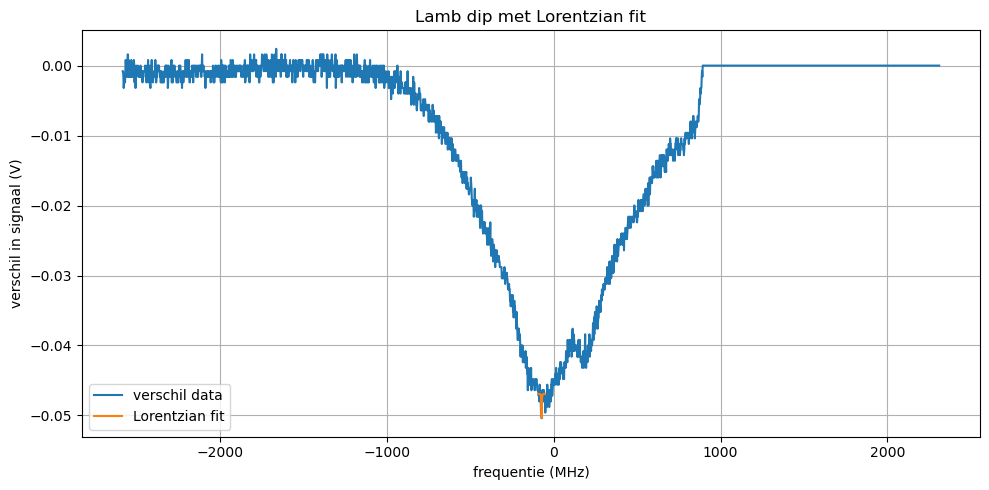

In [21]:
# zoek diepste Lamb dip in verschil signaal
idx_min_L = np.argmin(y_diff)
f_center_L = freq1_MHz.iloc[idx_min_L]

window_L = 20.0   # venster rond de smalle dip in MHz
mask_L = (freq1_MHz > f_center_L - window_L) & (freq1_MHz < f_center_L + window_L)

f_L = freq1_MHz[mask_L]
y_L = y_diff[mask_L]

# start schatting
p0_L = [min(y_L) - max(y_L),   # A (negatief, want dip)
        f_center_L,            # f0
        window_L / 10.0,       # gamma, vrij smal
        np.median(y_L)]        # offset

pars_L, _ = curve_fit(lorentzian, f_L, y_L, p0=p0_L)
A_L, f0_L, gamma_L, offset_L = pars_L

FWHM_line = 2 * gamma_L

print("Lorentzian fit Lamb dip:")
print(f"  centrum frequentie f0 = {f0_L:.2f} MHz")
print(f"  gamma = {gamma_L:.2f} MHz")
print(f"  FWHM (linewidth overgang) = {FWHM_line:.2f} MHz")

# plot fit
plt.figure()
plt.plot(freq1_MHz, y_diff, label="verschil data")
plt.plot(f_L, lorentzian(f_L, *pars_L), label="Lorentzian fit")
plt.xlabel("frequentie (MHz)")
plt.ylabel("verschil in signaal (V)")
plt.title("Lamb dip met Lorentzian fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
